In [1]:
# !pip install opencv-python
# !pip install stylegan2_pytorch

### Please ensure the following structure of your folder

    .
    ├── images                                  # X-ray and ct images
    ├── snapshots                               # Model weights
    ├── custom_unet_resnet.py                   # A modified U-net model
    ├── S3_Image synthesis_GAN_advanced.ipynb   # Part 2
    ├── S3_Image synthesis_GAN_basic.ipynb      # Part 1
    └── README.md          

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch.optim import Adam
import torch.nn as nn

In [3]:
plt.rcParams['figure.figsize'] = (6, 6)

In [4]:
device = 'cuda'

### StyleGAN2 for Chest X-ray generation

https://arxiv.org/abs/1812.04948

https://github.com/lucidrains/stylegan2-pytorch

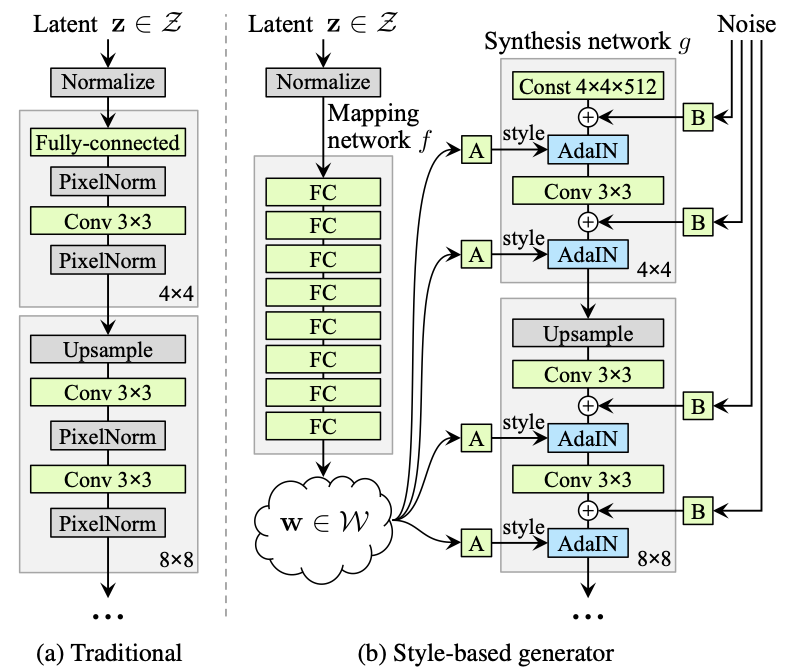

In [5]:
from stylegan2_pytorch import ModelLoader

In [6]:
imgs_path = './images/cxr_clear/'
def_psi = 0.75

In [7]:
# load a checkpoint
loader = ModelLoader(
    base_dir = './snapshots/stylegan2/',
    name = 'cxr_gan'                   
)

continuing from previous epoch - 81
loading from version 1.8.0


In [8]:
# z -> w
def noise_to_styles(loader, noise, trunc_psi = None):
    noise = noise.to(device)
    w = loader.model.GAN.SE(noise)
    if trunc_psi is not None:
        w = loader.model.truncate_style(w, trunc_psi)
    return w
# w -> image
def get_image_from_noise(loader, noise, trunc_psi = None):
    styles  = noise_to_styles(loader, noise, trunc_psi) # pass through mapping network
    images  = loader.styles_to_images(styles) # call the generator on intermediate style vectors
    return images

### Display some randomly generated chest x-rays

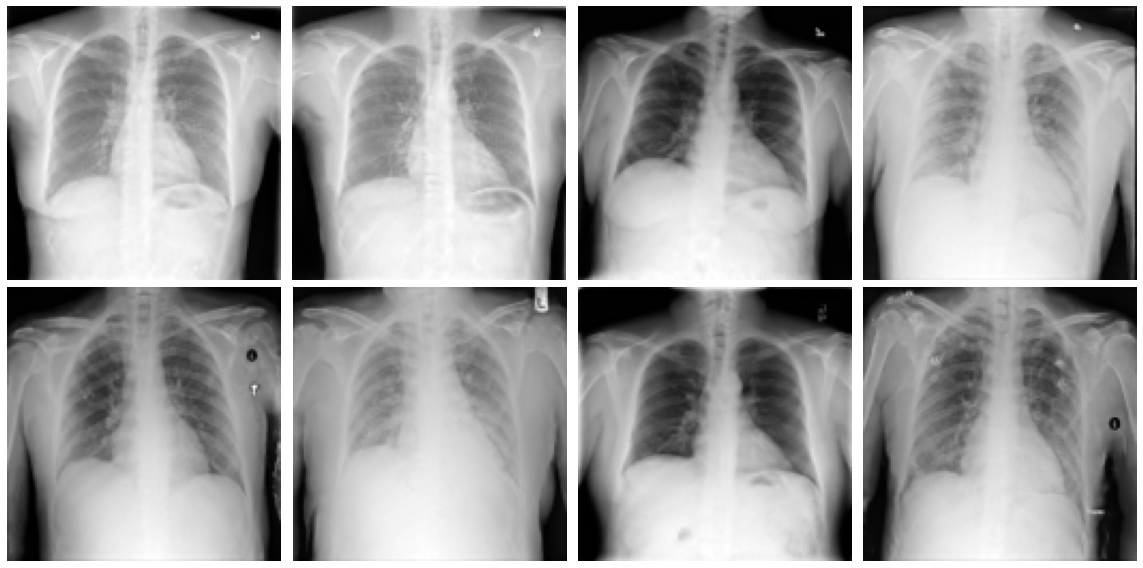

In [9]:
plt.figure(figsize=(16, 8))
for i in range(8):
    noise = torch.randn(1, 512).to(device)
    images = get_image_from_noise(loader, noise, def_psi)
    plt.subplot(2, 4, i+1)
    plt.imshow(images[0,0].cpu(), cmap='gray')
    plt.axis('off')
plt.tight_layout();

### Interpolation between images in z-space

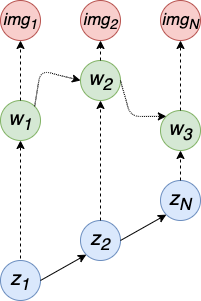

In [10]:
noise_start = torch.randn(1, 512).to(device)
noise_dest  = torch.randn(1, 512).to(device)
images_start  = get_image_from_noise(loader, noise_start, def_psi)
images_dest  = get_image_from_noise(loader, noise_dest, def_psi)

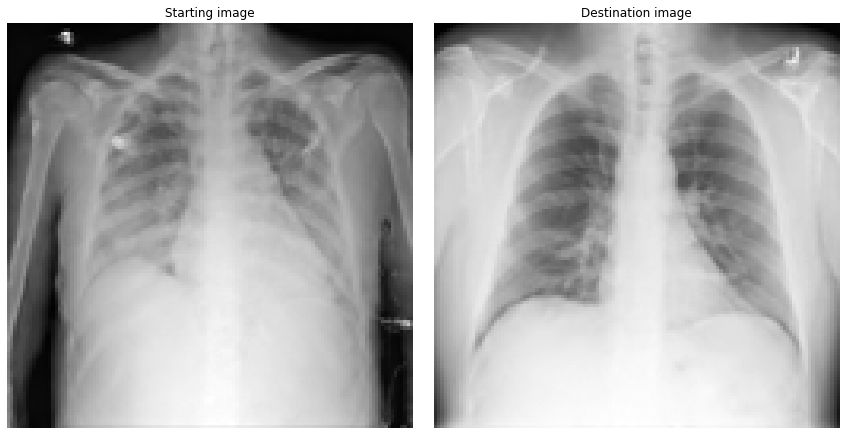

In [11]:
titles = ['Starting image', 'Destination image']
images = [images_start[0,0].cpu(), images_dest[0,0].cpu()]
plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout();

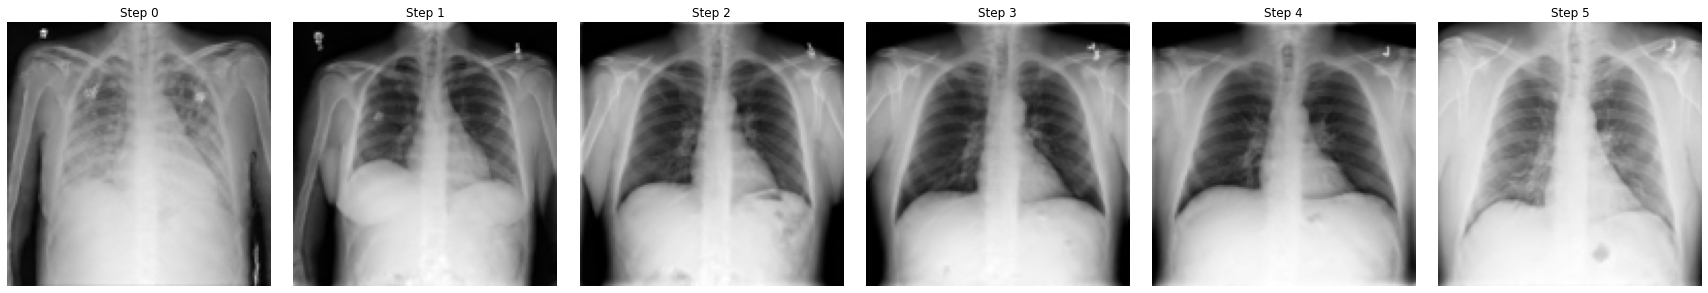

In [12]:
n_steps = 4
plt.figure(figsize=((n_steps+2)*4, 4))
for i in range(n_steps+2):
    noise = noise_start + i*(noise_dest - noise_start)/(n_steps+1)
    images  = get_image_from_noise(loader, noise, def_psi)
    plt.subplot(1, n_steps+2, i+1)
    plt.imshow(images[0,0].cpu(), cmap='gray')
    plt.title('Step {}'.format(i))
    plt.axis('off')
plt.tight_layout();

### Truncation trick in W-space

$$ w' = \bar w + \psi (w - \bar w)$$
$\bar w$ was calculated during the training

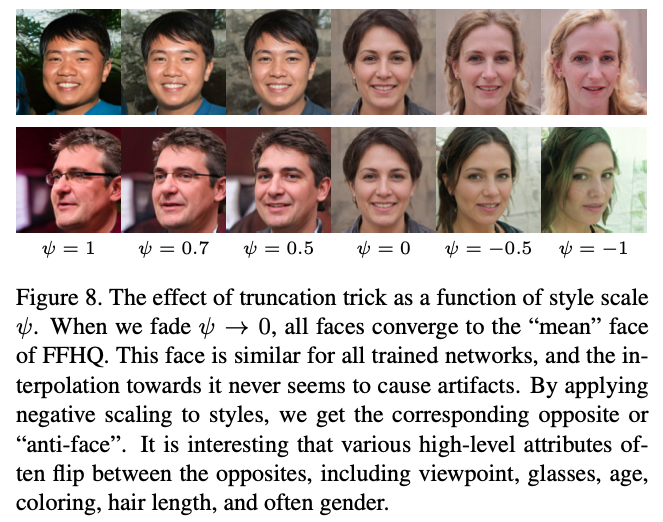

In [13]:
def plot_trunc_trick(n_steps, psi_min, psi_max, loader, noise):
    plt.figure(figsize=((n_steps+2)*4, 4))
    for i in range(n_steps+2):
        psi = psi_min + i*(psi_max - psi_min)/(n_steps+1)
        images  = get_image_from_noise(loader, noise, trunc_psi=psi)
        plt.subplot(1, n_steps+2, i+1)
        plt.imshow(images[0,0].cpu(), cmap='gray')
        plt.title('psi = {}'.format(psi))
        plt.axis('off')
    plt.tight_layout();

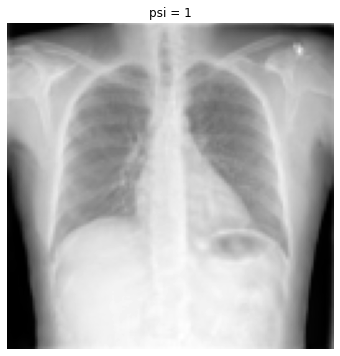

In [14]:
noise = torch.randn(1, 512).to(device)
images  = get_image_from_noise(loader, noise, trunc_psi=None)
plt.imshow(images[0,0].cpu(), cmap='gray')
plt.axis('off');
plt.title('psi = 1');

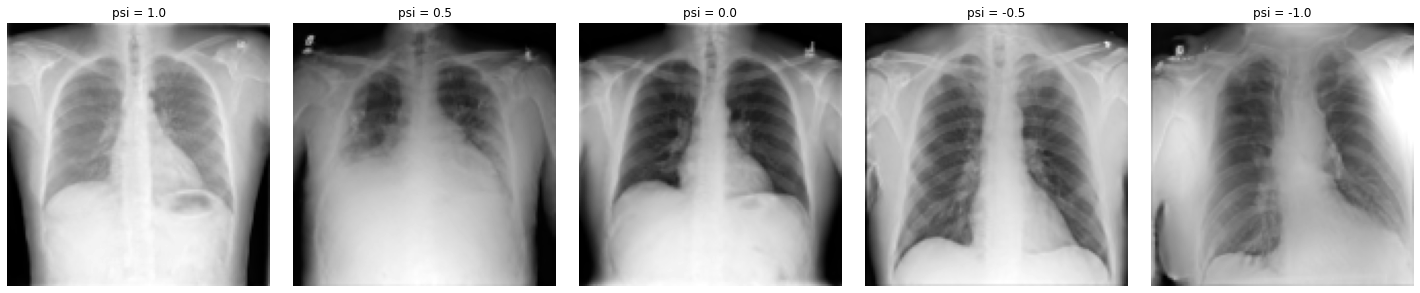

In [15]:
plot_trunc_trick(3,1,-1,loader, noise)

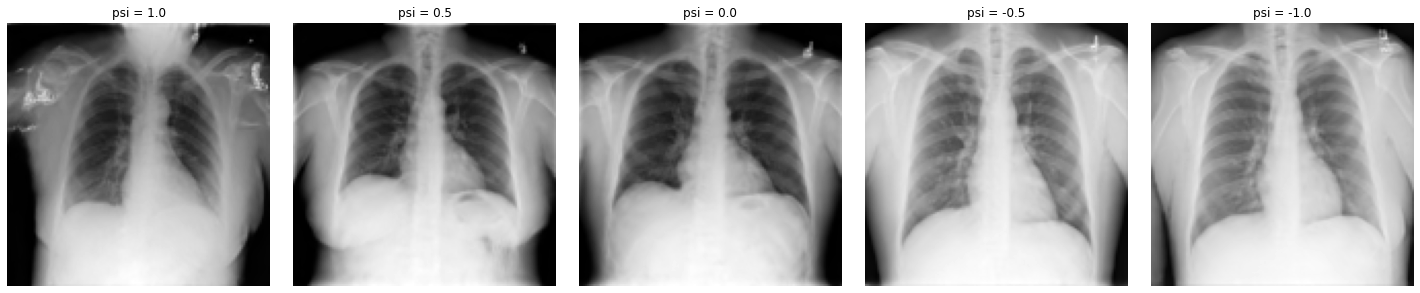

In [16]:
noise = torch.randn(1, 512).to(device)
plot_trunc_trick(3,1,-1,loader, noise)

### Find a corresponding latent vector z given an image

Image is fixed. $z$ is to be optimized.

In [17]:
batch_size = 1
image_size = 128

In [18]:
# aux. functions
def image_noise(n, im_size, device):
    return torch.FloatTensor(n, im_size, im_size, 1).uniform_(0., 1.).cuda(device)
def styles_def_to_tensor(styles_def):
    return torch.cat([t[:, None, :].expand(-1, n, -1) for t, n in styles_def], dim=1)

# z -> w
def noise_to_styles_S(loader, noise, trunc_psi = None):
    noise = noise.to(device)
    w = loader.model.GAN.SE(noise)
    if trunc_psi is not None:
        w = loader.model.truncate_style(w, trunc_psi)
    return w

# w -> img
def styles_to_images_G(loader, w):
    batch_size, *_ = w.shape
    num_layers = loader.model.GAN.GE.num_layers
    image_size = loader.model.image_size
    w_def = [(w, num_layers)]

    w_tensors = styles_def_to_tensor(w_def)
    noise = image_noise(batch_size, image_size, device = device)

    images = loader.model.GAN.GE(w_tensors, noise)
    return images

In [19]:
# read and preprocess an image
img_id = np.random.choice(os.listdir(imgs_path))
img = cv2.imread(os.path.join(imgs_path, img_id))
img = cv2.resize(img, (128,128)).astype(np.float32)
img = np.transpose(img, (2,0,1)) / 255.0
img_torch = torch.from_numpy(img).unsqueeze(0).to(device)

# generate a starting point for the optimization
# z = noise_opt
noise_opt = torch.randn(1, 512, requires_grad=True, device = device)
with torch.no_grad():
    style_opt = noise_to_styles_S(loader, noise_opt)
    img_opt = styles_to_images_G(loader, style_opt)

# define a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = Adam([noise_opt], lr=1e-3)

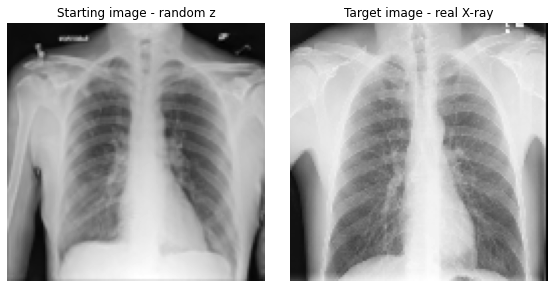

In [20]:
images = [img_opt.cpu()[0,0], img_torch.cpu()[0,0]]
titles = ['Starting image - random z', 'Target image - real X-ray']
plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i], cmap='gray');
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout();

In [21]:
n_iters = 1500
for i in range(n_iters):
    pred_style = noise_to_styles_S(loader, noise_opt)
    pred_img = styles_to_images_G(loader, pred_style)
    loss = criterion(pred_img, img_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1)%150==0:
        print('Iter {}, loss {}'.format(i, loss.item()))

Iter 149, loss 0.01279386691749096
Iter 299, loss 0.011592152528464794
Iter 449, loss 0.01126656960695982
Iter 599, loss 0.011378353461623192
Iter 749, loss 0.011298537254333496
Iter 899, loss 0.011109471321105957
Iter 1049, loss 0.01091378927230835
Iter 1199, loss 0.01076317485421896
Iter 1349, loss 0.010377148166298866
Iter 1499, loss 0.010416053235530853


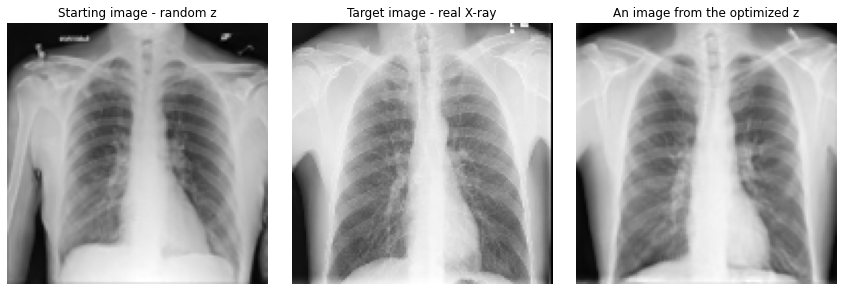

In [22]:
pred_img = pred_img.detach().cpu()
images = [img_opt.cpu()[0,0], img_torch.cpu()[0,0], pred_img[0,0]]
titles = ['Starting image - random z', 'Target image - real X-ray', 'An image from the optimized z']
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i], cmap='gray');
    plt.title(titles[i])
    plt.axis('off');
plt.tight_layout();